In [1]:
from dateutil import rrule
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime
from datetime import date
import pandas as pd

In [3]:
def calculateGlobal(asofdate, plotstates, states, boundsMap, predictionDay):
    report = []
    for state in states:
        item = dict()
        #ydate up to as of date
        ydata = globalcountryTSelected.loc[globalCountryTSelected['date']<=datetime.datetime.strptime(asofdate,'%m/%d/%y'),state]
        xdata = np.linspace(0,len(ydata)-1,len(ydata)) #available length
        
        xdata2 = np.linspace(0,480,481)
        base_a = '20200122'
        base = bdatetime.date(int(base_a[0:4]), int(base_a[4:6]),int(base_a[6:8]))
        date_list = [(base+datetime.timedelta(days=x)).strftime('%m/%d/%y') for x in xdata2]
        
        if state+'_low' in boundsMap:
            lowbounds = boundsMap[state+'_low']
        else:
            lowbounds = (-np.inf, -np.inf,-np.inf, -np.inf)
            
        if state+'_high' in boundsMap:
            highbounds = boundsMap[state+'_high']
        else:
            highbounds = (np.inf, np.inf, np.inf, np.inf)
            
        initialGuess = [0.15,10000,0.3,15]
        
        try:
            popt, pcov = curve_fit(richards, xdata,ydata, bounds=(lowbounds, highbounds), po = initialGuess, maxfev = 8000)
            
        except ValueError:
            print(state +" ValueError")
        except RunTimeError:
            print(state+ " RunTimeError")
            
        prediction = richards(xdata2, *popt)
        date10 = datetime.datetime.strptime(asofdate,'%m/%d/%y')+datetime.timedelta(days=predictionDay )
        date10str = date10.strftime('%m/%d/%y')
        date10I = date_list.index(date10str)
        date10prediction = int(prediction[date10I])
        
        dateCurrentI = date_list.index(asofdate)
        dateCUrrentVal = list(ydata)[dateCurrentI]
        item['State'] = state
        item['CurrentDate'] =asofdate
        item['CurrentValue']=dateCurrentVal
        item['Date'+str(predictionDay)] =date10str
        item['Date'+str(predictionDay)+'Prediction'] = date10prediction
        report.append(item)
        
        if state in plotstates:
            print("plot: "+state)
            plt.figure(figsize=(10,8))
            plt.plot(xdata,ydata,'o',label='actual data',fillstyle='none',markersize = 7)
            plt.plot(date_list,prediction,'r-',label = "Richards Model Fit: r={0:5.3f},k={1:5.3f},a={2:5.3f},tm={3:5.3f}".format(*tuple(popt)))
            plt.axvline(asofdate, color = 'blue',linestyle="--")
            plt.legend(loc = 'bottom right')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Positive Cases')
            plt.xticks(rotation = 45, fontsize = 6)#plt.xticks([0.2, 0.4, 0.6, 0.8, 1.],["Jan\n2009", "Feb\n2009", "Mar\n2009", "Apr\n2009", "May\n2009"])
            plt.title(state+' Richards Model Forecasts of Cumulative COVID-19 Cases Reported by '+ asofdate)
            plt.show()
    report_df = pd.DateFrame(report)
    return report_df
            
            

In [4]:
def richards(t, r , k, a, tm):
    I = k/pow((1+np.exp(-r*(t-tm))),1/a)
    return I

def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%y')
    

In [5]:
def calculate( asofdate, plotstates, states, boundsMap, predictionDay):
    report =[]
    curve_df = pd.DataFrame()
    for state in states:
        item = dict()
        data_state = datasetraw.loc[datasetraw['state']==state,:]
        data_state.sort_values(by = ['date'], inplace=True)
        ydata = data_state['positive']
        base_a = str(data_state['date'].tolist()[0])
        if state =='WA':
            xdata2 = np.linspace(0,465,466)
        else:
            xdata2 = np.linspace(0,430,431)
        # base = date.fromisformat('2020-03-04')
        base =datetime.date(int(base_a[0:4]), int(base_a[4:6]),int(base_a[6:8]))
        date_list = [(base+datetime.timedelta(days=x)).strftime('%m/%d/%y') for x in xdata2]
        #ydata up to the asofdate
        try:
            dateCurrentI = date_list.index(asofdate)
        except ValueError:
            print(state+" ValueError in as of date")
            continue
        
        dateCurrentVal = list(ydata)[dateCurrentI]
        ydata = list(ydata)[:(dateCurrentI+1)]
        xdata = np.linspace(0, len(ydata)-1,len(ydata))
        
        if state+'_low' in boundsMap:
            lowbounds = boundsMap[state+'_low']
        else:
            lowbounds = (-np.inf, -np.inf,-np.inf, -np.inf)
            
        if state+'_high' in boundsMap:
            highbounds = boundsMap[state+'_high']
        else:
            highbounds = (np.inf, np.inf, np.inf, np.inf)
            
        initialGuess = [0.15,10000,0.3,15]
        
        try:
            popt, pcov = curve_fit(richards, xdata, ydata, bounds = (lowbounds,highbounds), p0 = initialGuess, maxfev=8000)
        except ValueError:
            print(state+" ValueError")
        except RuntimeError:
            print(state+" RuntimeError")
            continue
        
        prediction = richards(xdata2, *popt)
        
        date10 = datetime.datetime.strptime(asofdate,'%m/%d/%y')+datetime.timedelta(days = predictionDay)
        date10str = date10.strftime('%m/%d/%y')
        try:
            date10I = date_list.index(date10str)
        except ValueError:
            print(state+" ValueError")
        except RuntimeError:
            print(state+" RuntimeError")
            continue
        date10prediction = int(prediction[date10I])
        
        item['State'] = state
        item['CurrentDate'] =asofdate
        item['CurrentValue']=dateCurrentVal
        item['Date'+str(predictionDay)] =date10str
        item['Date'+str(predictionDay)+'Prediction'] = date10prediction
        report.append(item)
        
        if state in plotstates:
            print("plot: "+state)
            if len(curve_df.index)==0:
                curve_df = pd.DataFrame({'date':date_list,state:prediction})               
            else:
                temp = pd.DataFrame({'date':date_list,state:prediction})
                curve_df = pd.merge(curve_df,temp,on=['date'])
                
            plt.figure(figsize=(10,8))
            plt.plot(xdata,ydata,'o',label='actual data',fillstyle='none',markersize = 7)
            plt.plot(date_list,prediction,'r-',label = "Richards Model Fit: r={0:5.3f},k={1:5.3f},a={2:5.3f},tm={3:5.3f}".format(*tuple(popt)))
            plt.axvline(asofdate, color = 'blue',linestyle="--")
            plt.legend(loc = 'bottom right')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Positive Cases')
            plt.xticks(rotation = 45, fontsize = 6)#plt.xticks([0.2, 0.4, 0.6, 0.8, 1.],["Jan\n2009", "Feb\n2009", "Mar\n2009", "Apr\n2009", "May\n2009"])
            plt.title(state+' Richards Model Forecasts of Cumulative COVID-19 Cases Reported by '+ asofdate)
            #plt.show()
            plt.savefig("/Users/yaodai/Documents/IHI/individual/individual_Project/data/"+plotstates[0]+".jpg",dpi=600,quality=100, optimize = True,progressive = True)
    report_df = pd.DataFrame(report)
    return report_df,curve_df    
    

In [6]:
def calcRC(row):
    try:
        measure = row.Date5Prediction/row.CurrentValue
    except ZeroDivisionError:
        print(row.State+ " state has ZeroDivisionError when calcualte risk category.")
        return 3
    
    if(measure)>2:
        return 1
    elif( measure<1.5 or row.CurrentValue<200):
        return 3
    else:
        return 2

In [7]:
def validator(row):
    measre = row.Date5Prediction - row.CurrentValue
    if measure<0:
        return 1
    else:
        return 0 
    

In [8]:
boundsMap = {
    "MI_low":(-np.inf, -np.inf,0,-np.inf),
    "MI_high":(np.inf,np.inf,np.inf,np.inf),
}

In [16]:
plotstates=['GA']
datasetraw = pd.read_csv('/Users/yaodai/Documents/IHI/project/states_20200917.csv',header='infer')
states = list(set(datasetraw['state'].tolist()))

asofdate = '09/14/20'
predictionDay = 5



<ipython-input-5-747cebfe69d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_state.sort_values(by = ['date'], inplace=True)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in exp
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: divide by zero encountered in true_divide
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in true_divide
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)


VA ValueError
ND ValueError
MA ValueError


<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in power
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)


AS ValueError
plot: GA


<ipython-input-5-747cebfe69d2>:80: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc = 'bottom right')
<ipython-input-5-747cebfe69d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_state.sort_values(by = ['date'], inplace=True)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in exp
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: divide by zero encountered in true_divide
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)


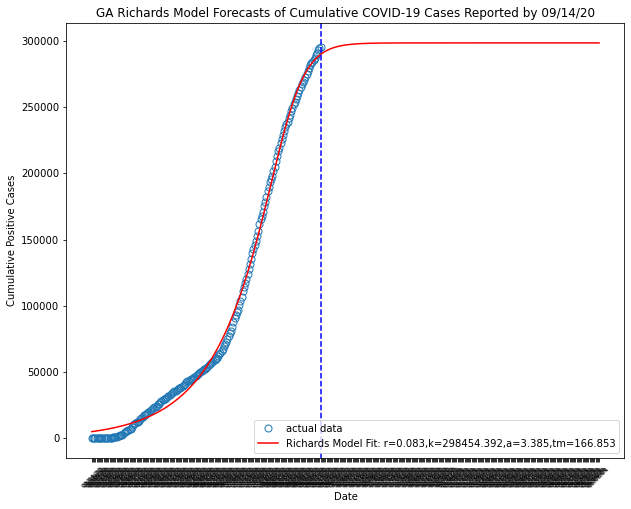

In [17]:
runbacktest = True
saveoutput = True
savecurveoutput = False
new_df,new_curve_df = calculate(asofdate, plotstates, states, boundsMap, predictionDay)

<ipython-input-35-08bb66e66740>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_state.sort_values(by = ['date'], inplace=True)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in exp
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: divide by zero encountered in true_divide
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in power
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in true_divide
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)


VA ValueError
AS ValueError
ND ValueError
MA ValueError


/Users/yaodai/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


plot: LA


<ipython-input-35-08bb66e66740>:80: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc = 'bottom right')
<ipython-input-35-08bb66e66740>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_state.sort_values(by = ['date'], inplace=True)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in exp
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: divide by zero encountered in true_divide
  I = k/pow((1+np.exp(-r*(t-tm))),1/a)
<ipython-input-4-93691378880f>:2: RuntimeWarning: overflow encountered in true_divide


VA ValueError
AS ValueError
ND ValueError
MA ValueError


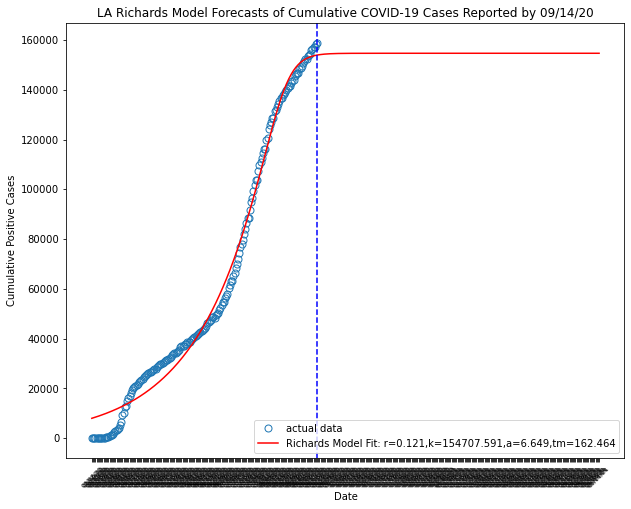

In [38]:
if runbacktest:
    backtestDate = (datetime.datetime.strptime(asofdate, '%m/%d/%y') - datetime.timedelta(days = predictionDay)).strftime('%m/%d/%y')
    backtest_df,  backtest_curve_df = calculate(backtestDate, [], states, boundsMap, predictionDay)
                    
    backtest_df2 = backtest_df[['State','Date'+str(predictionDay)+'Prediction']]
    backtest_df2.rename(inplace = True, 
                          columns = {'Date'+str(predictionDay)+'Prediction':'predicted as of '+str(predictionDay)+' days ago for currentdate'})
new_df,new_curve_df = calculate(asofdate, plotstates, states, boundsMap, predictionDay)

if runbacktest:
    ret_df = pd.merge(new_df, backtest_df2, on=['State'])
    ret_df = ret_df[['State','CurrentDate','CurrentValue','predicted as of '+str(predictionDay)+' days ago for currentdate','Date'+str(predictionDay),
                        'Date'+str(predictionDay)+'Prediction']]

    
else:
    ret_df=new_df

    


In [34]:
ret_df['Risk Category'] = ret_df.apply(calcRC, axis = 1)
ret_df.sort_values(by = ['CurrentValue'],inplace=True,ascending = False)
ret_df['Region']='US'

totalRet = ret_df #pd.concat([ret_df,ret_df_G])
asofdateSTR = (datetime.datetime.strptime(asofdate, '%m/%d/%y')).strftime('%Y-%m-%d')
#totalRet['validator'] = totalRet.apply(validator,axis = 1)
ret_df.to_csv('/Users/yaodai/Documents/IHI/individual/individual_project/data/20200914.csv',index=False)


AS state has ZeroDivisionError when calcualte risk category.
